<a href="https://colab.research.google.com/github/ced-sys/.py/blob/main/GeoThermoAI(Draft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install graphviz pydotplus

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
from IPython.display import display, Image
import pydotplus
import io

In [46]:
np.random.seed(42)

In [47]:
def generate_geothermal_data(n_samples=500):
  """
  Generate synthetic data for geothermal site classification with realistic relationships

  Parameters: n_samples (int): Number of smaples generate

  Returns: X(DataFrame): Features y(Features): Target labels
  """
  data=pd.DataFrame()

  #Heat flow (mW/ m**2)
  data['heat_flow']=np.random.gamma(shape=3, scale=20, size=n_samples)+20

  #Rock type (0: sedimentary, 1: plutonic, 2: Volcanic)
  data['rock_type']=np.random.choice([0,1,2], size=n_samples, p=[0.5, 0.3, 0.2])

  #Fault proximity (Km) - distance to nearest fault
  data['fault_distance']=np.random.exponential(scale=10, size=n_samples)

  #Hydrothermal alteration (0:None, 1: Weak, 2: Moderate, 3:Strong)
  data['alteration']=np.random.choice([0, 1, 2, 3], size=n_samples, p=[0.6, 0.2, 0.15, 0.05])

  #Resistivity (ohm-m)-low values can indicate hydrothermal fluids
  #Create a bimodal distribution to represent both conductive and resistive zones
  resistivity_high=np.random.lognormal(mean=5, sigma=1, size=int(n_samples*0.7))
  resistivity_low=np.random.lognormal(mean=2, sigma=0.5, size=n_samples-int(n_samples*0.7))
  data['resistivity']=np.concatenate([resistivity_high, resistivity_low])
  np.random.shuffle(data['resistivity'])

  #Surface Temperature anomaly
  data['temp_anomaly']=np.random.exponential(scale=2, size=n_samples)

  #Presence of Hot Springs or Fumaroles (0:None, 1:Present)
  data['hot_springs']=np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15])

  #Seismic activity (events per year in the vicinity)
  data['seismic_activity']=np.random.poisson(lam=2, size=n_samples)

  #Gravity anomal (mGal)
  data['gravity_anomaly']=np.random.normal(loc=0, scale=5, size=n_samples)

  #Geochemical Signatures (0:None, 1: Weak, 2: Strong)
  data['geochemical']=np.random.choice([0, 1, 2], size=n_samples, p=[0.7, 0.2, 0.1])

  #Createtarget variable based on realistic geological rules
  y=np.zeros(n_samples, dtype=int)

  #High potential (2) criteria
  high_potential=(
      ((data['heat_flow']>80)& (data['fault_distance']<5)& (data['resistivity']<20))|
      ((data['heat_flow']>80)& (data['fault_distance']<5)& (data['seismic_activity']>5))|
      ((data['hot_springs']>80)& (data['rock_type']==2)&(data['alteration']>=2)) |
      ((data['hot_springs']==1)& (data['alteration']>=2)& (data['temp_anomaly']>3)) |
      ((data['hot_springs']==1)& (data['geochemical']==2)& (data['resistivity']<30))

  )
  y[high_potential]=2

  #Moderate Potential (1) Criteria
  moderate_potential=(
      ((data['heat_flow']>60)& (data['heat_flow']<=80)& (data['fault_distance']<10))|
      ((data['heat_flow']>80)& (data['fault_distance']>=5)& (data['fault_distance']<10))|
      ((data['hot_springs']==1)& (data['alteration']==1))|
      ((data['heat_flow']>60)& (data['rock_type']==1)& (data['fault_distance']<15))|
      ((data['heat_flow']<=60)& (data['hot_springs']==1)&(data['alteration']<2))|
      ((data['heat_flow']>60)& (data['heat_flow']<=80)& (data['gravity_anomaly'].abs()>5))
  )

  #Only set to moderate ifnot already set to high
  moderate_potential=moderate_potential & (y!=2)
  y[moderate_potential]=1

  #Low potential (0) is default

  #Create target names forclarity
  y_names=pd.Series(y).map({0: "Low", 1:"Moderate", 2:"High"})

  #Shuffle data
  shuffled_indices=np.random.permutation(n_samples)
  return data.iloc[shuffled_indices].reset_index(drop=True), y[shuffled_indices], y_names.iloc[shuffled_indices].reset_index(drop=True)




In [48]:
#Generate the data
X, y_numeric, y_names=generate_geothermal_data(n_samples=1000)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  np.random.shuffle(data['resistivity'])
<ipython-input-47-52d7dffe6536>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.random.shuffle(data['resistivity'])
<ipython-input-47-52d7dffe6536>:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is w

In [49]:
print("Generated Dataset Shape:", X.shape)
print("\nFeature Statistics:")
print(X.describe().round(2))

Generated Dataset Shape: (1000, 10)

Feature Statistics:
       heat_flow  rock_type  fault_distance  alteration  resistivity  \
count    1000.00    1000.00         1000.00     1000.00      1000.00   
mean       81.55       0.67            9.83        0.63       169.45   
std        34.34       0.77           10.04        0.91       259.24   
min        22.07       0.00            0.00        0.00         1.80   
25%        56.24       0.00            2.86        0.00        11.07   
50%        74.91       0.00            6.75        0.00        82.24   
75%        99.58       1.00           13.54        1.00       202.70   
max       211.42       2.00           77.24        3.00      2365.85   

       temp_anomaly  hot_springs  seismic_activity  gravity_anomaly  \
count       1000.00      1000.00           1000.00          1000.00   
mean           2.07         0.14              2.02            -0.09   
std            2.01         0.34              1.47             4.98   
min       

In [50]:
print('\nTarget Distribution:')
print(pd.Series(y_names).value_counts())


Target Distribution:
Low         534
Moderate    400
High         66
Name: count, dtype: int64


In [51]:
print("\nSample Data:")
sample_df=X.copy()
sample_df['potential']=y_names
print(sample_df.head())


Sample Data:
    heat_flow  rock_type  fault_distance  alteration  resistivity  \
0  141.658260          1       23.842130           0    32.940336   
1   66.998545          0        4.670043           2    47.162529   
2   72.177736          2        2.748305           0    26.900963   
3   65.296431          1        6.312416           2     7.968175   
4   66.324172          2       15.789965           3   598.619031   

   temp_anomaly  hot_springs  seismic_activity  gravity_anomaly  geochemical  \
0      1.585521            0                 1        -0.253860            1   
1      1.779715            0                 3        -3.872352            2   
2      6.556230            1                 1        -3.198105            0   
3      2.546658            0                 3         0.164572            0   
4      1.058010            0                 6        -5.466280            0   

  potential  
0       Low  
1  Moderate  
2  Moderate  
3  Moderate  
4  Moderate  


In [52]:
#Prepare feature names with descriptions for better interpretation
feature_names=[
    'Heat Flow (mW/m**2)',
    'Rck Type (0: Sed, 1:Plut, 2:Volc)',
    'Fault Distance (km)',
    'Alteration (0-3)',
    'Resistivity (ohm-m)',
    'Temperature Anomaly (C)',
    'Hot Springs (0:No, 1:Yes)',
    'Seismic Activity (events/year)',
    'Gravity Anomaly (mGal)',
    'Geochemical Signatures (0-2)'
]

In [53]:
#Create class names for better readability
class_names=['Low Potential', 'Moderate Potential', 'High Potential']

In [54]:
#Split the data
X_train, X_test, y_train,y_test=train_test_split(X, y_numeric, test_size=0.25, random_state=42, stratify=y_numeric)

In [55]:
#Train a decision tree classifier
#We'll limit the dpeth to get a more interpretable tree
dt=DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=10, random_state=42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [56]:
#Evaluate the model
y_pred=dt.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
                    precision    recall  f1-score   support

     Low Potential       0.88      0.98      0.93       134
Moderate Potential       0.95      0.83      0.89       100
    High Potential       1.00      0.88      0.93        16

          accuracy                           0.91       250
         macro avg       0.94      0.89      0.92       250
      weighted avg       0.92      0.91      0.91       250



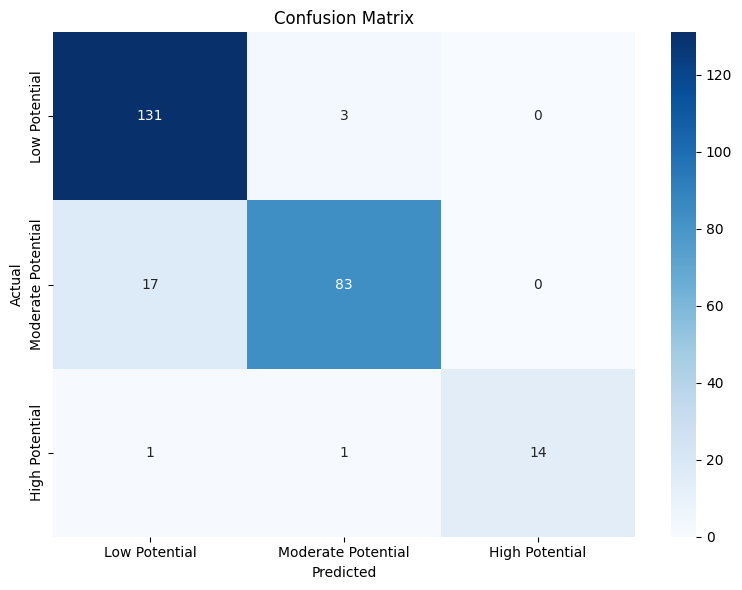

In [57]:
#Plot confusion matrix
plt.figure(figsize=(8, 6))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

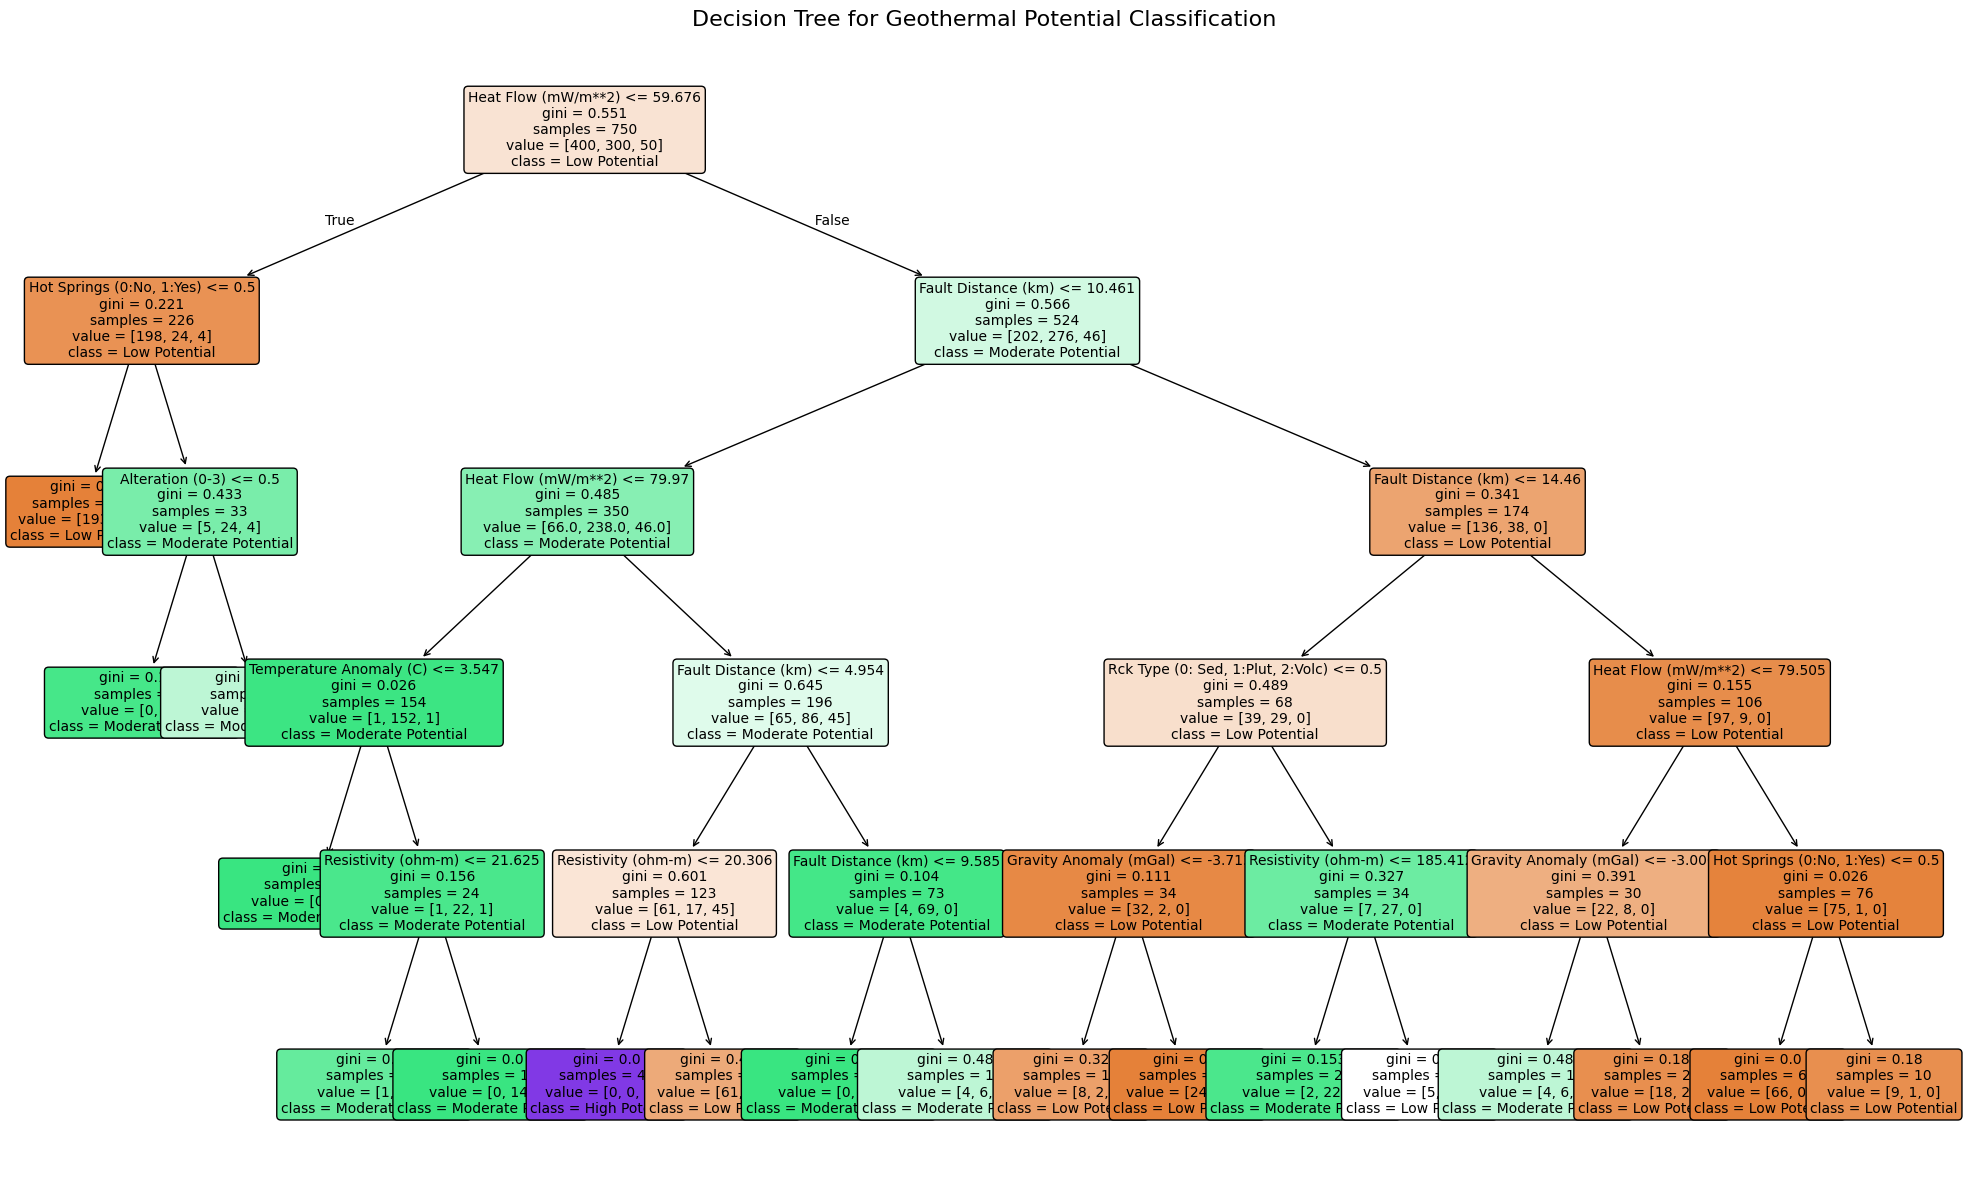

In [58]:
#Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Geothermal Potential Classification", fontsize=16)
plt.tight_layout()
plt.show()

In [59]:
#Create a more visually appealing tree using grpahviz
dot_data=export_graphviz(
    dt,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True
)

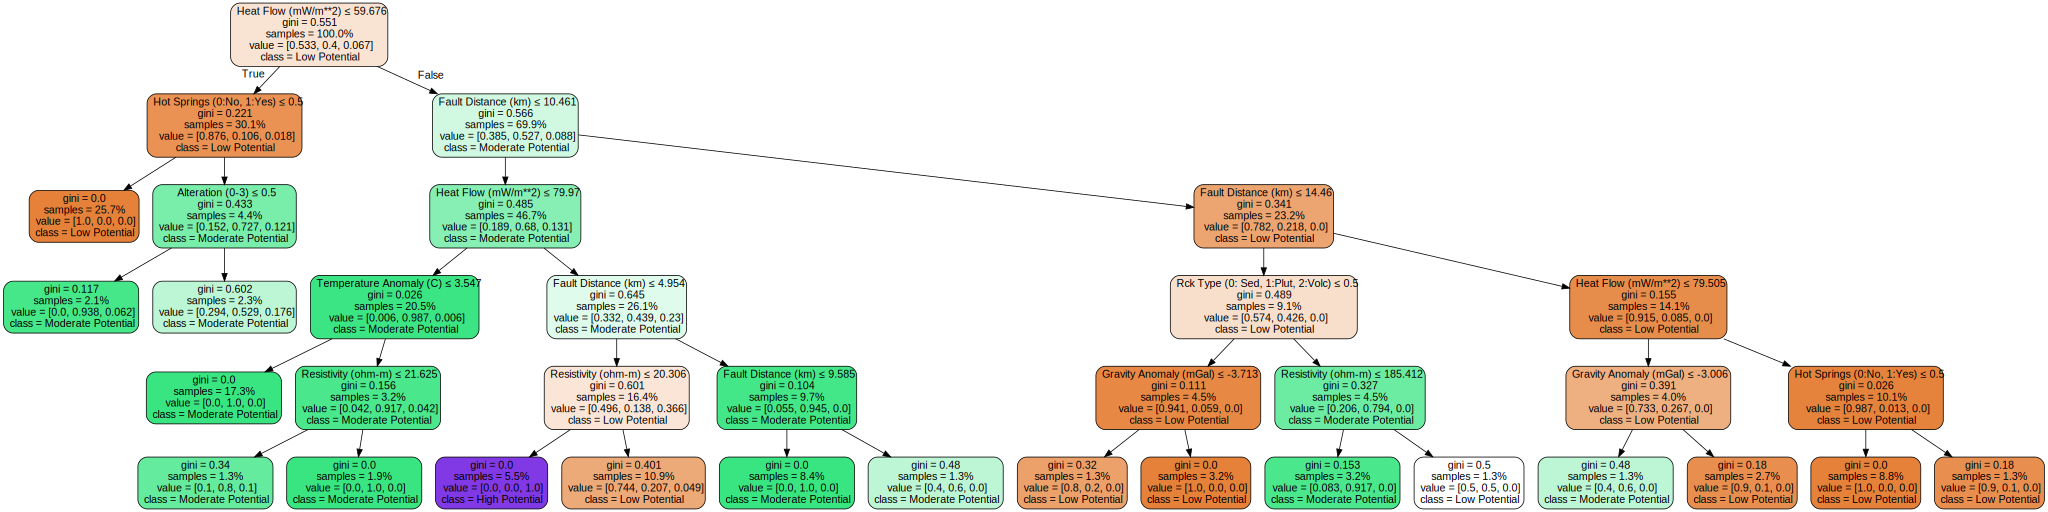

In [60]:
#Generate the graph
graph=graphviz.Source(dot_data)
display(graph)

In [61]:
#Save the visualization to a file
graph.render("geothermal_decision_tree", format="png", cleanup=True)

'geothermal_decision_tree.png'

In [62]:
#Feature importance analysis
importances=dt.feature_importances_
indices=np.argsort(importances)[::-1]

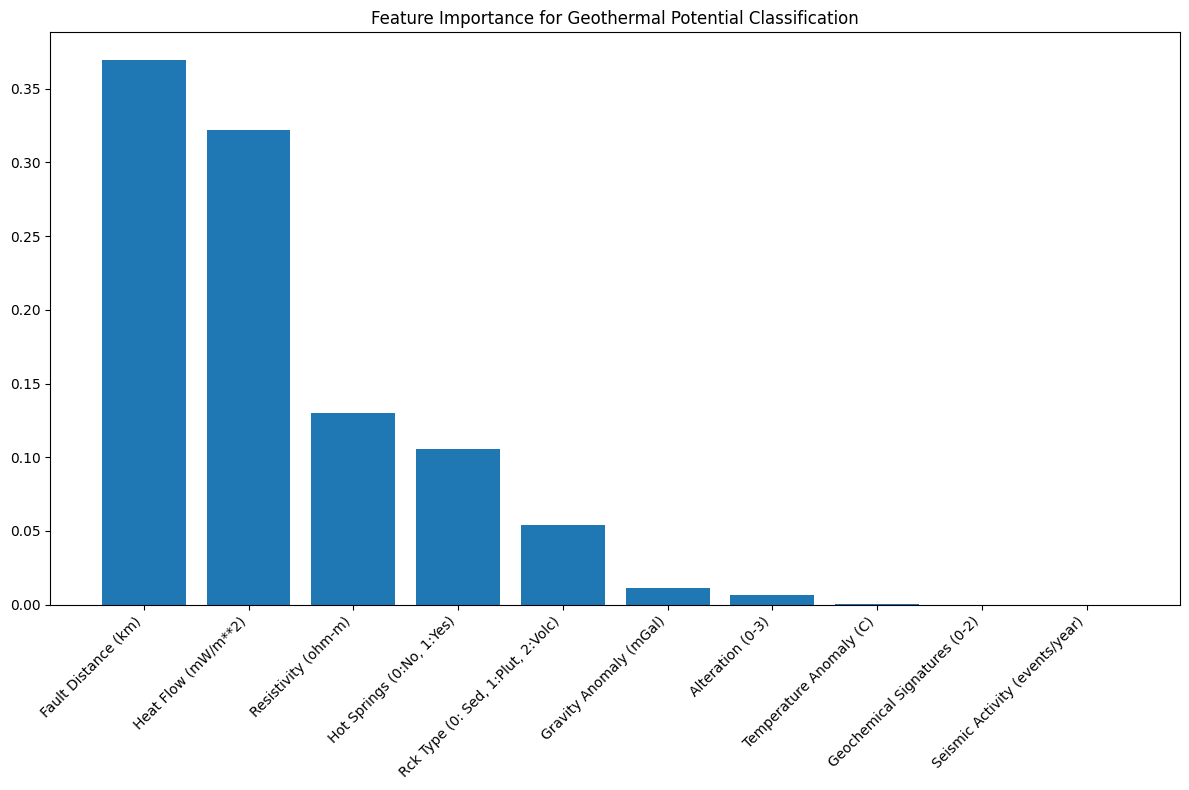

In [63]:
plt.figure(figsize=(12, 8))
plt.title("Feature Importance for Geothermal Potential Classification")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [64]:
print("\nFeature Importance Ranking:")
for i in indices:
  print(f"{feature_names[i]}: {importances[i]:.4f}")


Feature Importance Ranking:
Fault Distance (km): 0.3696
Heat Flow (mW/m**2): 0.3218
Resistivity (ohm-m): 0.1297
Hot Springs (0:No, 1:Yes): 0.1058
Rck Type (0: Sed, 1:Plut, 2:Volc): 0.0544
Gravity Anomaly (mGal): 0.0115
Alteration (0-3): 0.0065
Temperature Anomaly (C): 0.0006
Geochemical Signatures (0-2): 0.0000
Seismic Activity (events/year): 0.0000


In [65]:
#Create a function to classify new sites
def classify_site(heat_flow, rock_type, fault_distance, alteration, resistivity, temp_anomaly, hot_springs, seismic_activity, gravity_anomaly, geochemical):
  """
  Classify a geothermal site based on its features

  Parameters:
  -heat_flow: Heat Flow (mW/m**2)
  -rock_type: Rock Type (0: Sedimentary, 1: Plutonic, 2: Volcanic)
  -fault_distance: Distance to the nearest fault (km)
  -alteration: Hydrothermal Alteraion (0: None, 1: Weak, 2:Moderate, 3: Strong)
  -resistivity: Electrical resistiity (ohm-m)
  -temp_anomaly: Surface temperature anomaly (degree Celsius above background)
  -hot_springs: Presence of hot springs (0: No, 1: Yes)
  -seismic_activity: Seismic activity (Events per year)
  -gravity_anomaly: Gravity anomaly (mGal)
  -geochemical: Geochemical Signatures (0: None, 1: Weak, 2: Strong)

  Returns:
  -Predicted class and probability
  """
  features=np.array([[
      heat_flow, rock_type, fault_distance, alteration, resistivity,
      temp_anomaly, hot_springs, seismic_activity, gravity_anomaly, geochemical
  ]])

  predicted_class=dt.predict(features)[0]
  probabilities=dt.predict_proba(features)[0]

  print(f"Predicted Class: {class_names[predicted_class]}")
  print("Class Probabilities:")
  for i, cls in enumerate(class_names):
    print(f" {cls}: {probabilities[i]:.2f}")

  return predicted_class, probabilities


In [66]:
#Example usage of the classification function
print("\nExample Site Classification:")
classify_site(
    heat_flow=85, #High Heat flow
    rock_type=2, #Volcanic
    fault_distance=3, #Close to fault
    alteration=2, #Moderate alteration
    resistivity=15, #Low resistivity
    temp_anomaly=2.5, #Moderate temperature anomaly
    hot_springs=1, #Hot springs present
    seismic_activity=4, #Some seismic activity
    gravity_anomaly=3.2, #Minor gravity anomaly
    geochemical=2 #Strong geochemical signatures
)


Example Site Classification:
Predicted Class: High Potential
Class Probabilities:
 Low Potential: 0.00
 Moderate Potential: 0.00
 High Potential: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


(np.int64(2), array([0., 0., 1.]))

In [67]:
#Create an interactive function to input newsites
def interactive_classification():
  print("\n---Geothermal Site Potential Classification ---")

  heat_flow=float(input("Heat Flow (mW/m**2):"))

  print("Rock Type Options:")
  print("): Sedimentary")
  print("1: Plutonic")
  print("2: Volcanic")
  rock_type=int(input("Rock Type (0-2):"))

  fault_distance=float(input("Fault distance (km):"))

  print("Hydrothermal Alteration Options:")
  print("0: None")
  print("1: Weak")
  print("2: Moderate")
  print("3: Strong")
  alteration=int(input("Alteration Level (0-3):"))

  resistivity=float(input("Electrical Resistivity (ohm-m):"))
  temp_anomaly=float(input("Surface Temperature Anomaly (C above background):"))

  hot_springs=int(input("Hot Springs Present? (0: No, 1:Yes):"))
  seismic_activity=float(input("Seismic Activity (events/ year):"))
  gravity_anomaly=float(input("Gravity anomaly(mGal):"))

  print("Geochemical Signatures Options:")
  print("0: None")
  print("1: Weak")
  print("2: Strong")
  geochemical=int(input("Geochemical Signature Level (0-2):"))

  print("\nClassification Results:")
  classify_site(
      heat_flow, rock_type, fault_distance, alteration, resistivity,
      temp_anomaly, hot_springs, seismic_activity, gravity_anomaly, geochemical
  )



In [68]:
#Run the interactive classification
interactive_classification()

#Create path visualization for a sample site
def visualize_decision_path(sample):
  """Visualize the decision path for a specific sample"""
  decision_path=dt.decision_path(sample.reshape(1, -1))

  #Get node feature threshold
  node_indicator=decision_path.toarray()[0]
  leaf_id=dt.apply(sample.reshape(1, -1))[0]

  #Get all nodes in the decision path
  node_index=np.where(node_indicator==1)[0]

  #Print decision path
  print("Decision Path for Sample:")
  for i, node_id in enumerate(node_index):
    #Check if it's a leaf node
    if node_id==leaf_id:
      print(f"Leaf node {node_id}: Predicted class={class_names[dt.tree_.value[node_id].argmax()]}")
      break

    #Get the feature and threshold
    feature=dt.tree_.feature[node_id]
    threshold=dt.tree_.threshold[node_id]

    #Print decision rule
    if sample[feature]<=threshold:
      print(f"Node {node_id}: {feature_names[feature]}={sample[feature]:.2f}<={threshold:.2f}-> Left")
    else:
      print(f"Node {node_id}: {feature_names[feature]}={sample[feature]:.2f}>{threshold:.2f}-> Right")


---Geothermal Site Potential Classification ---
Heat Flow (mW/m**2):67
Rock Type Options:
): Sedimentary
1: Plutonic
2: Volcanic
Rock Type (0-2):2
Fault distance (km):345
Hydrothermal Alteration Options:
0: None
1: Weak
2: Moderate
3: Strong
Alteration Level (0-3):3
Electrical Resistivity (ohm-m):456
Surface Temperature Anomaly (C above background):43
Hot Springs Present? (0: No, 1:Yes):2
Seismic Activity (events/ year):2
Gravity anomaly(mGal):34
Geochemical Signatures Options:
0: None
1: Weak
2: Strong
Geochemical Signature Level (0-2):2

Classification Results:
Predicted Class: Low Potential
Class Probabilities:
 Low Potential: 0.90
 Moderate Potential: 0.10
 High Potential: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [69]:
example_site=np.array([85, 2, 3, 3, 15, 2.5, 1, 4, -3.2, 2])
print("\nExample Site Features:")
for i, feature in enumerate(feature_names):
  print(f"{feature}:{example_site[i]}")


Example Site Features:
Heat Flow (mW/m**2):85.0
Rck Type (0: Sed, 1:Plut, 2:Volc):2.0
Fault Distance (km):3.0
Alteration (0-3):3.0
Resistivity (ohm-m):15.0
Temperature Anomaly (C):2.5
Hot Springs (0:No, 1:Yes):1.0
Seismic Activity (events/year):4.0
Gravity Anomaly (mGal):-3.2
Geochemical Signatures (0-2):2.0


In [70]:
visualize_decision_path(example_site)

Decision Path for Sample:
Node 0: Heat Flow (mW/m**2)=85.00>59.68-> Right
Node 6: Fault Distance (km)=3.00<=10.46-> Left
Node 7: Heat Flow (mW/m**2)=85.00>79.97-> Right
Node 13: Fault Distance (km)=3.00<=4.95-> Left
Node 14: Resistivity (ohm-m)=15.00<=20.31-> Left
Leaf node 15: Predicted class=High Potential


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [71]:
def explain_rules():
  """Extract and explain the main decision rules from the tree"""
  #Get the tree structure
  n_nodes=dt.tree_.node_count
  children_left=dt.tree_.children_left
  children_right=dt.tree_.children_right
  feature=dt.tree_.feature
  threshold=dt.tree_.threshold
  value=dt.tree_.value

  #Extract paths to all leaf nodes
  leaf_nodes=[]
  for i in range (n_nodes):
    if children_left[i]==children_right[i]:
      leaf_nodes.append(i)

  #Print rules for each class
  for class_idx, class_name in enumerate(class_names):
    print(f"\nKey rules for {class_name}:")

    #Find leaf nodes for this class
    class_leaves=[]
    for leaf in leaf_nodes:
      if np.argmax(value[leaf])==class_idx:
        class_leaves.append(leaf)

    #Get the most pure leaves
    pure_leaves=[]
    for leaf in leaf_nodes:
      total=value[leaf].sum()
      purity=value[leaf][0][class_idx]/total
      if purity>0.7:
        pure_leaves.append((leaf, purity))

    #Sort by purity
    pure_leaves.sort(key=lambda x:x[1], reverse=True)

    #Print the top rules
    for idx, (leaf, purity) in enumerate(pure_leaves[:3]):
      if idx>=3:
        break

        #Trace path from root to leaf
        node_id=leaf
        path=[]
        while node_id !=0:
          parent_found=False
          for i in range(n_nodes):
            if children_left[i]==node_id or children_right[i]==node_id:
              path.append((i, "<"))
            else:
              path.append((i, ">"))
            node_id=i
            parent_found=True
            break

          if not parent_found:
            break

        #Print the rule
        rule=[]
        path.reverse()
        for node_id, direction in path:
          feat=feature[node_id]
          thresh=threshold[node_id]
          rule.append(f"{feature_names[feat]}{direction}{thresh:.2f}")

        print(f"Rule {idx+1}: IF{'AND'.join(rule)} THEN{class_name} (Confidence: {purity:.2f})")



In [72]:
explain_rules()


Key rules for Low Potential:

Key rules for Moderate Potential:

Key rules for High Potential:


In [73]:
def print_tree_text(tree,feature_names, class_names,spacing="|-"):
  """Print a decision tree in text form"""
  def _print_tree_recurse(node, depth=0):
    indent=' '*depth+spacing

    #Checkis leaf node
    if tree.tree_.children_left[node]==tree.tree_.children_right[node]:
      class_counts=tree.tree_.value[node][0]
      total=class_counts.sum()
      distribution=class_counts/total
      majority_class=np.argmax(class_counts)

      #Format the class probabilities
      probs=[f"{class_names[i]}: {prob:.2f}" for i, prob in enumerate(distribution)]
      print(f"{indent}->Class: {class_names[majority_class]} ({', '.join(probs)})")
      return

    #For decsion nodes
    feature_index=tree.tree_.feature[node]
    threshold=tree.tree_.threshold[node]

    print(f"{indent}{feature_names[feature_index]}<={threshold:.2f}")
    _print_tree_recurse(tree.tree_.children_left[node], depth+1)

    print(f"{indent}{feature_names[feature_index]}> {threshold:.2f}")
    _print_tree_recurse(tree.tree_.children_right[node], depth+1)

  print("Decision Tree Structure:")
  _print_tree_recurse(0)

In [74]:
print("\nText Representation of the Decision Tree:")
print_tree_text(dt, feature_names, class_names)


Text Representation of the Decision Tree:
Decision Tree Structure:
|-Heat Flow (mW/m**2)<=59.68
 |-Hot Springs (0:No, 1:Yes)<=0.50
  |-->Class: Low Potential (Low Potential: 1.00, Moderate Potential: 0.00, High Potential: 0.00)
 |-Hot Springs (0:No, 1:Yes)> 0.50
  |-Alteration (0-3)<=0.50
   |-->Class: Moderate Potential (Low Potential: 0.00, Moderate Potential: 0.94, High Potential: 0.06)
  |-Alteration (0-3)> 0.50
   |-->Class: Moderate Potential (Low Potential: 0.29, Moderate Potential: 0.53, High Potential: 0.18)
|-Heat Flow (mW/m**2)> 59.68
 |-Fault Distance (km)<=10.46
  |-Heat Flow (mW/m**2)<=79.97
   |-Temperature Anomaly (C)<=3.55
    |-->Class: Moderate Potential (Low Potential: 0.00, Moderate Potential: 1.00, High Potential: 0.00)
   |-Temperature Anomaly (C)> 3.55
    |-Resistivity (ohm-m)<=21.62
     |-->Class: Moderate Potential (Low Potential: 0.10, Moderate Potential: 0.80, High Potential: 0.10)
    |-Resistivity (ohm-m)> 21.62
     |-->Class: Moderate Potential (Low P

In [75]:
#Create scatter plot matri for selected features
selected_features=['heat_flow', 'fault_distance', 'resistivity', 'alteration']
selected_features_names=[feature_names[X.columns.get_loc(feat)] for feat in selected_features]

In [76]:
#Createa subset o the data
plot_data=X[selected_features].copy()
plot_data['potential']=y_names

<Figure size 1600x2100 with 0 Axes>

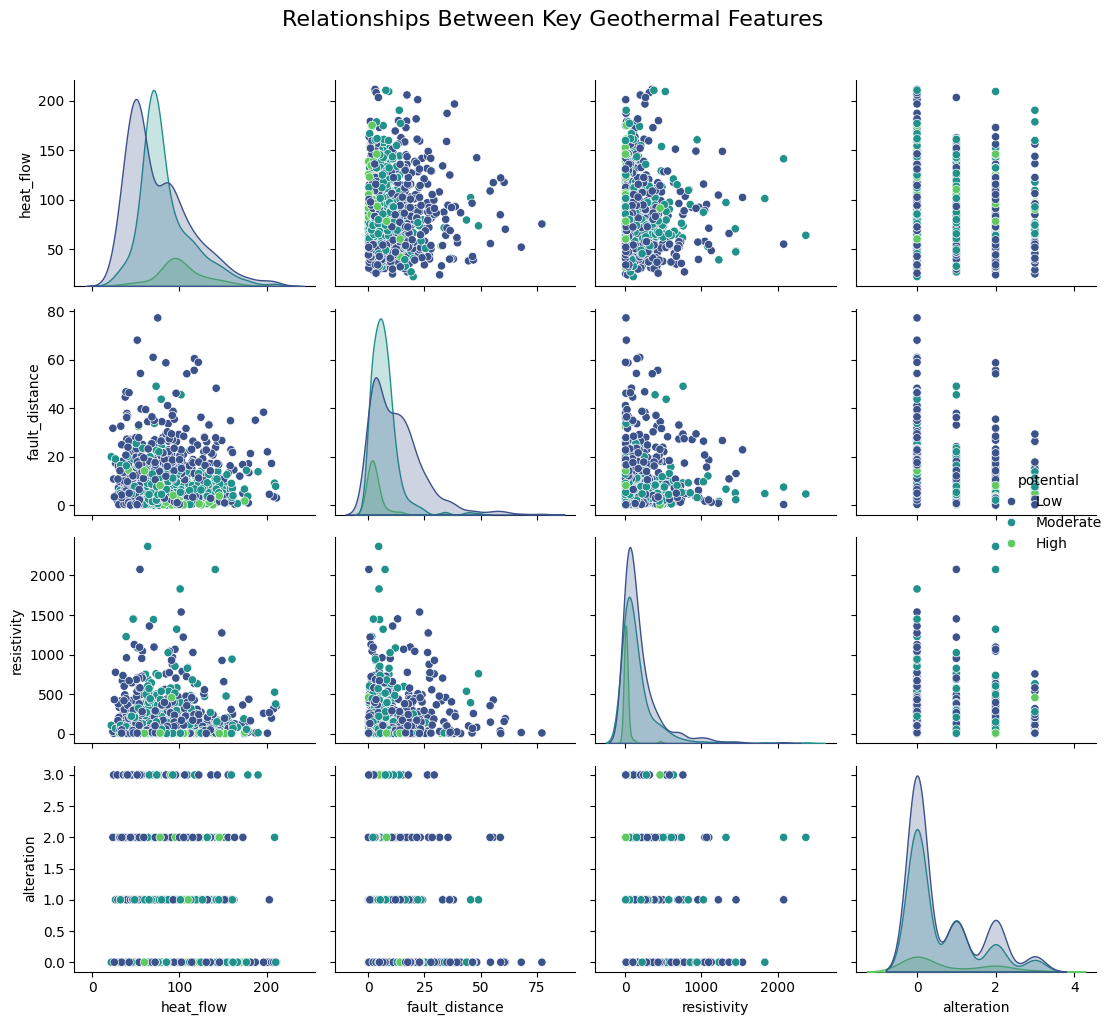

In [77]:
plt.figure(figsize=(16, 21))
sns.pairplot(plot_data, hue='potential', palette='viridis')
plt.suptitle('Relationships Between Key Geothermal Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [78]:
print("\nAnalysis Complete!")


Analysis Complete!
